# Zekmachines

__Name__: Aletta van Straatten


# Reflection 

1. Pre-processing: We decided initially it would be best to only focus on words, we used the function isalpha to delete all string with non alphabetic tokens. This caused some issues with for example words that contain symbols such as "-". But our model yielded an higher accuracy with deleting these non-alphabetic symbols containing strings then when they are not deleted, so we decided to keep it this way. Each word is being set to lowercase and we applied lemmatization which improved our results, compared to not using lemmatization. The preprocessing obviously is done on both the queries and the documents. 


2. Tokenization: We used NLTK to tokenize the string. And the PorterStemmer from NLTK. PorterStemmer is known for its simplicity and speed. Because we stemmed the index we also need to stem the queries.


3. Indexing: We made an inverted frequency index wherein the frequency off each term for each document is saved. The more specific properties such as corpus length can all be substracted from this inverted index, but this is rather slow to re-calculate this for every query. Therefore our ranking algorithms are all made up out of classes, and whenever a property of the index is used inside this ranking algorithm, these properties are substracted when the class is initialised. 


4. Ranking: The three classes / algorithms all produce a list containing 1000 highest scoring documents. This list contains tuples with two elements: the document name and the corresponding score. Based on this list of tuples a dataframe is created that can later on be used to calculate the MAP among other values.


5. Tuning your models: With the LM model we made it so that with Jelinek Mercer smoothing the Lambda parameter is bigger the shorter the query is, because in a query with few words, it's more important that these words are present in a doc than with a long query. For BM25 we did change the parameters based on the MAP and got the optimal values a = 1.2 and b = 0.75. We tried to optimise the TFIDF model by changing the idf calculation from np.log10(N / df) to np.log10( (N + alpha) / (df + alpha)) where alpha is a parameter that can be changed, but this didnt change anything for the MAP so we decided to leave the formula as it is.


6. Evaluation: (Algo evaluation) For the evaluation we used trec eval which caused some issues due to an incorrect format we used initially. But as told before we were able to optimise the BM25 hyper parameters in the end by simply running 20 different alpha values and 20 different beta values (this took quite some time). (Project evaluation) This project made us realise that working with data is not only about knowing how to program a specific algorithm, but also about reading data and understanding how to work with data based on what you see. A simple misunderstanding can cause an "unfixable error" and quite some stress. Next time we will try to understand the problem and data better before we start writing code, this was a big lesson for all of us.

# Code for the search engine

## Preliminaries

In [1]:
'''
Please import all packages here (and optionally download nltk data if you do not have it).
'''
import timeit
from IPython.display import clear_output
import os
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import re
from collections import Counter, defaultdict
from tqdm import tqdm_notebook
from IPython.display import clear_output, display, HTML

import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pickle
from nltk.stem import WordNetLemmatizer


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
#%load_ext memory_profiler # if needed run !pip install memory_profiler


In [2]:
# do make and run a test
#%cd ../../../trec_eval-9.0.7
#! make 
#!head test/results.test   # how does the output look?

In [3]:
# handy paths
trec_data_path= '../../../trec_uncompressed_1/' # Make sure it is placed in the path '../../../trec_uncompressed_1/trec_eval-9.0.7/
trec_eval_path= trec_data_path+'trec_eval-9.0.7/'


# just testing
test_dir= trec_eval_path+'test/'

# test whether your data is OK # should return a list of directories
%ls -l $trec_data_path

# test your trec_eval: should return: map                   	all	0.1785
! $trec_eval_path/trec_eval -m map  $trec_eval_path/test/qrels.test $trec_eval_path/test/results.test 

total 20
drwxr-xr-x 7 wouter wouter 4096 sep 18  2020 docs/
drwxr-xr-x 4 wouter wouter 4096 okt 15 11:50 notebooks/
drwxr-xr-x 3 wouter wouter 4096 okt 16 12:12 qrels/
drwxr-xr-x 2 wouter wouter 4096 okt  9 22:17 queries/
drwxr-xr-x 4 wouter wouter 4096 okt  5 13:45 trec_eval-9.0.7/
map                   	all	0.1785


# Your code

## helper functions

preprocess any string and return an empty string if it is not a valid string, this is used both for the queries and the indexing

In [4]:
def preprocess_string(unprocessed_string, stopwords):
    if not unprocessed_string.isalpha():
        return ""
    
    processed_string = unprocessed_string.lower()
    
    if processed_string in stopwords:
        return ""
    
    # lemming
    lemmatizer = WordNetLemmatizer() 
    processed_string = lemmatizer.lemmatize(processed_string)
    
    return processed_string

## Indexing

In [5]:
def dd():
    return defaultdict(int)

In [6]:
def create_index(path_list):
    index = defaultdict(dd) 
    stopwords = set(nltk.corpus.stopwords.words('english'))
    
    for i, path in enumerate(path_list):
        clear_output(wait=True)
        print("creating index:", int(i/len(path_list) * 100), '%')

        try:
            f = open(path, "r")
            content = f.read()

            soup = BeautifulSoup(content, 'html.parser')
            input_tag = soup.find_all("text")
            
            
            for docId, document in zip(soup.find_all("docno"), soup.find_all("text")):
                tokens = nltk.tokenize.word_tokenize(document.get_text())

                tokens[:] = map(lambda x: preprocess_string(x, stopwords), tokens)
                for token in tokens:
                    if not token:
                        continue

                    index[token.lower()][docId.get_text().replace(" ", "")] += 1
            
        except:
            print("file kan niet gelezen worden") 
    
    clear_output(wait=True)
    return index



## Queries

In [7]:
class Query: 
    def __init__(self, path, sort):
        self.queries = [] #list of list with words from query
        self.query_ids = []
        self.query_paths = []
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.path_to_paths(path)
        self.process_from_paths(sort)
    
    def path_to_paths(self, path):
        q_paths = []
        for root, subdirectories, files in os.walk(path):
            for file in files:
                if 'readme' not in file and 'DS_Store' not in file:
                    q_paths.append(os.path.join(root, file)) 
                    
        self.query_paths = q_paths
        
    def process_from_paths(self, sort):
        tmp = 0
        if sort == 'train':
            tmp = 1
            
        with open(self.query_paths[tmp], "rb") as file:
            queries = pd.read_csv(file)
            for title, ID in zip(queries['title'], queries['q_id']):
                title_list = []
                for word in title.split():
                    tmp_w = preprocess_string(word, self.stopwords)
                    if not tmp_w:
                        continue

                    title_list.append(tmp_w)

                self.queries.append(title_list)
                self.query_ids.append(ID)

## Ranking algorithms

In [8]:
                                                                                          
                                                                                          
# BBBBBBBBBBBBBBBBB   MMMMMMMM               MMMMMMMM 222222222222222    555555555555555555 
# B::::::::::::::::B  M:::::::M             M:::::::M2:::::::::::::::22  5::::::::::::::::5 
# B::::::BBBBBB:::::B M::::::::M           M::::::::M2::::::222222:::::2 5::::::::::::::::5 
# BB:::::B     B:::::BM:::::::::M         M:::::::::M2222222     2:::::2 5:::::555555555555 
#   B::::B     B:::::BM::::::::::M       M::::::::::M            2:::::2 5:::::5            
#   B::::B     B:::::BM:::::::::::M     M:::::::::::M            2:::::2 5:::::5            
#   B::::BBBBBB:::::B M:::::::M::::M   M::::M:::::::M         2222::::2  5:::::5555555555   
#   B:::::::::::::BB  M::::::M M::::M M::::M M::::::M    22222::::::22   5:::::::::::::::5  
#   B::::BBBBBB:::::B M::::::M  M::::M::::M  M::::::M  22::::::::222     555555555555:::::5 
#   B::::B     B:::::BM::::::M   M:::::::M   M::::::M 2:::::22222                    5:::::5
#   B::::B     B:::::BM::::::M    M:::::M    M::::::M2:::::2                         5:::::5
#   B::::B     B:::::BM::::::M     MMMMM     M::::::M2:::::2             5555555     5:::::5
# BB:::::BBBBBB::::::BM::::::M               M::::::M2:::::2       2222225::::::55555::::::5
# B:::::::::::::::::B M::::::M               M::::::M2::::::2222222:::::2 55:::::::::::::55 
# B::::::::::::::::B  M::::::M               M::::::M2::::::::::::::::::2   55:::::::::55   
# BBBBBBBBBBBBBBBBB   MMMMMMMM               MMMMMMMM22222222222222222222     555555555     
                                                                                          


class BM25: 
    def __init__(self, Query, index, alpha=1.2, beta=0.75):
        self.alpha = alpha
        self.beta = beta
        self.nr_docs = self.nr_docs(index)
        self.avg_docl = self.avg_docl(index)
        self.docl_dict = self.docl_dict(index)
        self.queries = Query.queries
        self.rank_score = self.rank_score(index)
        self.final_df = self.rankdict_to_df(self.rank_score, Query)
        
    def nr_docs(self, index):
        """ returns the number of documents in the index """
        all_docs = set()
        for key in index:
            for docname in index[key]:
                all_docs.add(docname)
        
        return len(list(all_docs))
    
    def avg_docl(self, index):
        total = 0
        for key in index:
            total += sum(index[key].values())
                
        return total / self.nr_docs
    
    def docl_dict(self, index):
        doclength = defaultdict(int)
        for key in index:
            for docname in index[key]:
                doclength[docname] += index[key][docname]
                
        return doclength
        
    def rank_score(self, index):
        rank = []
        for i, q in enumerate(self.queries):
            scores = defaultdict(int)
            for word in q:
                if word not in index: continue
                
                N = self.nr_docs
                n = len(index[word])
                
                idf = np.log10((N - n + 1 / 2) / (n + 1 / 2) + 0.3)
                for docname in index[word]:
                    tf = index[word][docname]
                    numerator = (self.alpha + 1) * tf
                    docl = self.docl_dict[docname]
                    denominator = (self.alpha * (self.beta * (docl / self.avg_docl) + (1 - self.beta))) + tf
                    scores[docname] += idf * numerator / denominator
            
            rank.append(sorted(scores.items(), key=lambda x: x[1], reverse=1)[:1000])

        return [rank]
    
    def rankdict_to_df(self, rank_score, Query):
        data = []
        for query in rank_score:
            for i, docname in enumerate(query):
                docId = Query.query_ids[i]
                for j, result in enumerate(docname):
                    name, score = result
                    data.append([docId, 'Q0', name, j + 1, score, '12602426'])
                
        return pd.DataFrame(data)

In [9]:
    
# TTTTTTTTTTTTTTTTTTTTTTTFFFFFFFFFFFFFFFFFFFFFFIIIIIIIIIIDDDDDDDDDDDDD      FFFFFFFFFFFFFFFFFFFFFF
# T:::::::::::::::::::::TF::::::::::::::::::::FI::::::::ID::::::::::::DDD   F::::::::::::::::::::F
# T:::::::::::::::::::::TF::::::::::::::::::::FI::::::::ID:::::::::::::::DD F::::::::::::::::::::F
# T:::::TT:::::::TT:::::TFF::::::FFFFFFFFF::::FII::::::IIDDD:::::DDDDD:::::DFF::::::FFFFFFFFF::::F
# TTTTTT  T:::::T  TTTTTT  F:::::F       FFFFFF  I::::I    D:::::D    D:::::D F:::::F       FFFFFF
#         T:::::T          F:::::F               I::::I    D:::::D     D:::::DF:::::F             
#         T:::::T          F::::::FFFFFFFFFF     I::::I    D:::::D     D:::::DF::::::FFFFFFFFFF   
#         T:::::T          F:::::::::::::::F     I::::I    D:::::D     D:::::DF:::::::::::::::F   
#         T:::::T          F:::::::::::::::F     I::::I    D:::::D     D:::::DF:::::::::::::::F   
#         T:::::T          F::::::FFFFFFFFFF     I::::I    D:::::D     D:::::DF::::::FFFFFFFFFF   
#         T:::::T          F:::::F               I::::I    D:::::D     D:::::DF:::::F             
#         T:::::T          F:::::F               I::::I    D:::::D    D:::::D F:::::F             
#       TT:::::::TT      FF:::::::FF           II::::::IIDDD:::::DDDDD:::::DFF:::::::FF           
#       T:::::::::T      F::::::::FF           I::::::::ID:::::::::::::::DD F::::::::FF           
#       T:::::::::T      F::::::::FF           I::::::::ID::::::::::::DDD   F::::::::FF           
#       TTTTTTTTTTT      FFFFFFFFFFF           IIIIIIIIIIDDDDDDDDDDDDD      FFFFFFFFFFF          

class TFIDF:
    def __init__(self, Query, index):
        """
        Query: Query object
        index: Inverted index of all the documents (datatype a dict of dicts with integers)
        """
        self.queries = Query.queries
        self.nr_docs = self.nr_docs(index)
        self.docl_dict = self.docl_dict(index)
        self.rankings = self.ranking(index)
        self.final_df = self.rankdict_to_df(self.rankings, Query)
        
    def nr_docs(self, index):
        """ returns the number of documents in the index """
        all_docs = set()
        for key in index:
            all_docs.add(index[key].values())
        
        return len(list(all_docs))
    
    def docl_dict(self, index):
        """ returns a dictionary with as key document names from the index and as value the length of this document """
        doclength = defaultdict(int)
        for key in index:
            for docname in index[key]:
                doclength[docname] += index[key][docname]
                
        return doclength
        
    def ranking(self, index):
        rank = []
        for i, q in enumerate(self.queries):
            query_vec = np.ones((1,len(q)))[0]
            query_vec = list((query_vec)/np.linalg.norm(query_vec))

            score = {}
            doc_vectors = defaultdict(lambda: [0]*len(q))
            length_query = np.sqrt((np.array(list(Counter(q).values())) ** 2).sum())
            

            for i, word in enumerate(q):
                if word not in index: 
                    continue
                                    
                N = self.nr_docs
                df = sum(index[word].values())
                for docname in index[word]:
                    tf = index[word][docname]
                    idf = np.log10(N / df)
                    # normalisation doesnt happen here yet since this isnt the final vector
                    doc_vectors[docname][i] = tf * idf
                    
            for docn in doc_vectors:
                docv = doc_vectors[docn]
                
                if sum(docv) == 0:
                    continue
                    
                # norm here
                docv = list((docv) / np.linalg.norm(docv))
                score[docn] = np.dot(query_vec, docv)
                      
            rank.append(sorted(score.items(), key=lambda x: x[1], reverse=True)[:1000])       

        return [rank]
    
    
    def rankdict_to_df(self, rank_score, Query):
        data = []
        for query in rank_score:
            for i, docname in enumerate(query):
                docId = Query.query_ids[i]
                for j, result in enumerate(docname):
                    name, score = result
                    data.append([docId, 'Q0', name, j + 1, score, '12602426'])
                
        return pd.DataFrame(data)

In [10]:
# LLLLLLLLLLL             MMMMMMMM               MMMMMMMM
# L:::::::::L             M:::::::M             M:::::::M
# L:::::::::L             M::::::::M           M::::::::M
# LL:::::::LL             M:::::::::M         M:::::::::M
#   L:::::L               M::::::::::M       M::::::::::M
#   L:::::L               M:::::::::::M     M:::::::::::M
#   L:::::L               M:::::::M::::M   M::::M:::::::M
#   L:::::L               M::::::M M::::M M::::M M::::::M
#   L:::::L               M::::::M  M::::M::::M  M::::::M
#   L:::::L               M::::::M   M:::::::M   M::::::M
#   L:::::L               M::::::M    M:::::M    M::::::M
#   L:::::L         LLLLLLM::::::M     MMMMM     M::::::M
# LL:::::::LLLLLLLLL:::::LM::::::M               M::::::M
# L::::::::::::::::::::::LM::::::M               M::::::M
# L::::::::::::::::::::::LM::::::M               M::::::M
# LLLLLLLLLLLLLLLLLLLLLLLLMMMMMMMM               MMMMMMMM  

class LM:
    def __init__(self, Query, index):
        """
        Query: Query object
        index: Inverted index of all the documents (datatype a dict of dicts with integers)
        """
        self.queries = Query.queries
        self.nr_docs = self.nr_docs(index)
        self.docl_dict, self.corpusl = self.docl_dict_and_corpuslength(index)
        self.rankings = self.ranking(index)
        self.final_df_M, self.final_df_D = self.rankdict_to_dfs(self.rankings[0], self.rankings[1], Query)
        
    def nr_docs(self, index):
        """ returns the number of documents in the index """
        all_docs = set()
        for key in index:
            all_docs.add(index[key].values())
        
        return len(list(all_docs))
    
    def docl_dict_and_corpuslength(self, index):
        """ returns a dictionary with as key document names from the index and as value the length of this document """
        doclength = defaultdict(int)
        corpuslength = 0
        for key in index:
            for docname in index[key]:
                tmp = index[key][docname]
                doclength[docname] += tmp
                corpuslength += index[key][docname]
                
        return doclength, corpuslength
        
    def ranking(self, index):
        rank_M = []
        rank_D = []
        for i, q in enumerate(self.queries):
            scores_M = defaultdict(lambda:1)
            scores_D = defaultdict(lambda:1)

            Lambda = max(0.1, 1 - (0.01 * len(q)))
            for word in q:
                if word not in index: continue
                
                colMLE = sum(index[word].values()) / self.corpusl

                for docname in index[word]:
                    docMLE = index[word][docname] / self.docl_dict[docname]
                    scores_M[docname] *= docMLE * Lambda + colMLE * (1 - Lambda)
                    
                    alpha = index[word][docname] / self.nr_docs
                    scores_D[docname] *= (alpha * colMLE + index[word][docname]) / (alpha + self.docl_dict[docname])

            rank_M.append(sorted(scores_M.items(), key=lambda x: x[1], reverse=1)[:1000]) 
            rank_D.append(sorted(scores_D.items(), key=lambda x: x[1], reverse=1)[:1000]) 

        return [rank_M], [rank_D]
    
    
    
    def rankdict_to_dfs(self, rank_M, rank_D, Query):
        data = []
        for query in rank_M:
            for i, docname in enumerate(query):
                docId = Query.query_ids[i]
                for j, result in enumerate(docname):
                    name, score = result
                    data.append([docId, 'Q0', name, j + 1, score, '12602426'])
                    
        df_M = pd.DataFrame(data)
        
        data = []
        for query in rank_D:
            for i, docname in enumerate(query):
                docId = Query.query_ids[i]
                for j, result in enumerate(docname):
                    name, score = result
                    data.append([docId, 'Q0', name, j + 1, score, '12602426'])
               
        df_D = pd.DataFrame(data)
        
        return df_M, df_D

## Run all

 ------------ train queries ------------ 
For the TFIDF model, 82 queries are evaluated. For these queries there are 80144 documents retrieved of which 2674 are relevant. In total there were 13430 relevant documents. This comes down to a MAP of 0.0355

For the BM25 model, 82 queries are evaluated. For these queries there are 80144 documents retrieved of which 3997 are relevant. In total there were 13430 relevant documents. This comes down to a MAP of 0.0824

For the LM_M model, 82 queries are evaluated. For these queries there are 80144 documents retrieved of which 340 are relevant. In total there were 13430 relevant documents. This comes down to a MAP of 0.0012

For the LM_D model, 82 queries are evaluated. For these queries there are 80144 documents retrieved of which 340 are relevant. In total there were 13430 relevant documents. This comes down to a MAP of 0.0013

 ------------ graphs and tables for train queries ------------ 
for train set;
A table with MAP values and interpolated

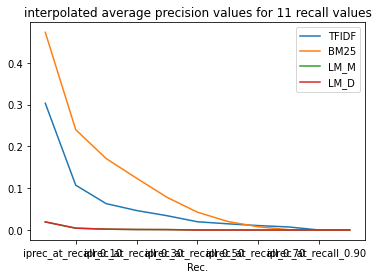

for train set;
 averaged 11 point interpolated precision recall graphs


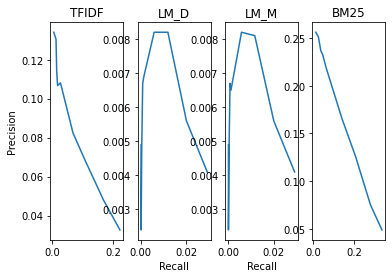

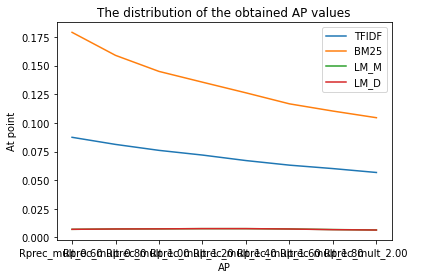

 ------------ test queries ------------ 
For the TFIDF model, 82 queries are evaluated. For these queries there are 80144 documents retrieved of which 2674 are relevant. In total there were 13430 relevant documents. This comes down to a MAP of 0.0355

For the BM25 model, 82 queries are evaluated. For these queries there are 80144 documents retrieved of which 3997 are relevant. In total there were 13430 relevant documents. This comes down to a MAP of 0.0824

For the LM_M model, 82 queries are evaluated. For these queries there are 80144 documents retrieved of which 340 are relevant. In total there were 13430 relevant documents. This comes down to a MAP of 0.0012

For the LM_D model, 82 queries are evaluated. For these queries there are 80144 documents retrieved of which 340 are relevant. In total there were 13430 relevant documents. This comes down to a MAP of 0.0013

 ------------ graphs and tables for test queries ------------ 
for test set;
A table with MAP values and interpolated av

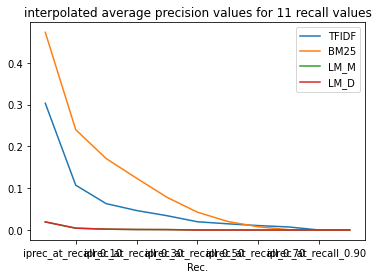

for test set;
 averaged 11 point interpolated precision recall graphs


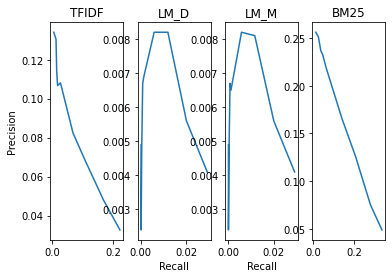

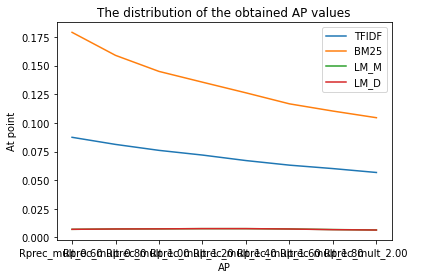

True

In [15]:
def evaluate(index, studid):
    for run in ["train","test"]:
        print(" ------------ {} queries ------------ ".format(run))
        query = Query('../../queries', run)

        bm25 = BM25(query, index)
        bm25.final_df.to_csv('results/BM25_{}_{}_results.csv'.format(run, studid), sep='\t', header=False, index=False)

        tfidf = TFIDF(query, index)
        tfidf.final_df.to_csv('results/TFIDF_{}_{}_results.csv'.format(run, studid), sep='\t', header=False, index=False)

        lm = LM(query, index)
        lm.final_df_M.to_csv('results/LM_M_{}_{}_results.csv'.format(run, studid), sep='\t', header=False, index=False)
        lm.final_df_D.to_csv('results/LM_D_{}_{}_results.csv'.format(run, studid), sep='\t', header=False, index=False)
        
        
        # Plotting the information
        MAP_table = pd.DataFrame(columns=['Rec.'])
        r_to_p = pd.DataFrame() 
        AP_distr = pd.DataFrame(columns=['AP'] )
        for model in ["TFIDF", "BM25", "LM_M", "LM_D"]:          
            qrel_file = trec_data_path+'qrels/qrels_{}.txt'.format(run)
            results_file = 'results/{}_{}_{}_results.csv'.format(model, run, studid)

            ### Overall Statistics ###
            num_q = ! $trec_eval_path/trec_eval -m num_q $qrel_file $results_file
            num_q = pd.DataFrame(data=num_q)[0].str.split('\tall\t',expand=True)
            num_ret = ! $trec_eval_path/trec_eval -m num_ret $qrel_file $results_file
            num_ret = pd.DataFrame(data=num_ret)[0].str.split('\tall\t',expand=True)
            num_rel = ! $trec_eval_path/trec_eval -m num_rel $qrel_file $results_file
            num_rel = pd.DataFrame(data=num_rel)[0].str.split('\tall\t',expand=True)
            num_rel_ret = ! $trec_eval_path/trec_eval -m num_rel_ret $qrel_file $results_file
            num_rel_ret = pd.DataFrame(data=num_rel_ret)[0].str.split('\tall\t',expand=True)
            tmap = ! $trec_eval_path/trec_eval -m map $qrel_file $results_file
            tmap = pd.DataFrame(data=tmap)[0].str.split('\tall\t',expand=True)
            print('For the {} model, {} queries are evaluated. For these queries there are {} documents retrieved of which {} are relevant. In total there were {} relevant documents. This comes down to a MAP of {}\n'.format(model, num_q[1][0], num_ret[1][0], num_rel_ret[1][0], num_rel[1][0], tmap[1][0]))

            #  Create an averaged 11 point interpolated precision recall graph for your three systems.
            #  RECALL AGAINST PRECISION
            r = ! $trec_eval_path/trec_eval -m recall.5,10,15,20,30,100,200,500,1000 $qrel_file $results_file
            rdf = pd.DataFrame(data=r)[0].str.split('\tall\t',expand=True)

            p = ! $trec_eval_path/trec_eval -m P.5,10,15,20,30,100,200,500,1000 $qrel_file $results_file
            pdf = pd.DataFrame(data=p)[0].str.split('\tall\t',expand=True)

            r_to_p['Recall{}'.format(model)] = rdf[1] #  {}'.format(model)
            r_to_p['Precision{}'.format(model)] = pdf[1]

            r_to_p[['Recall{}'.format(model),'Precision{}'.format(model)]] = r_to_p[['Recall{}'.format(model),'Precision{}'.format(model)]].apply(pd.to_numeric)


            #  Create a graph with for each system, the distribution of the obtained AP values
            AP = ! $trec_eval_path/trec_eval -m Rprec_mult.0.40,0.60,0.80,1.00,1.20,1.40,1.60,1.80,2.00 $qrel_file $results_file
            AP = pd.DataFrame(data=AP)[0].str.split('\tall\t',expand=True)

            if AP_distr['AP'].empty:
                AP_distr['AP'] = AP[0]

            AP_distr[model] = AP[1]

            #  Create a (pandas) table with MAP values and interpolated average precision values for 11 recall values, for your three system
            recs = ! $trec_eval_path/trec_eval -m iprec_at_recall.0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00 -m map $qrel_file $results_file
            recs = pd.DataFrame(data=recs)[0].str.split('\tall\t',expand=True)

            if MAP_table['Rec.'].empty:
                MAP_table['Rec.'] = recs[0]

            MAP_table[model] = recs[1]

            #  Create two plots for your LM models, one for Jellinek-Mercer smoothing and one for Dirichlet smoothing.


        #  print graphs and tables
        print(" ------------ graphs and tables for {} queries ------------ ".format(run))

        ##  AP Table
        print('for',run,'set;\nA table with MAP values and interpolated average precision values for 11 recall values\n',MAP_table )

        MAP_table[["TFIDF", "BM25", "LM_M", "LM_D"]] = MAP_table[["TFIDF", "BM25", "LM_M", "LM_D"]].apply(pd.to_numeric).drop(0)
        MAP_table.plot(x='Rec.', y=["TFIDF", "BM25", "LM_M", "LM_D"], kind="line")
        plt.title('interpolated average precision values for 11 recall values')
        plt.show()

        ## PR Plot
        print('for',run,'set;\n averaged 11 point interpolated precision recall graphs')
        fig = plt.figure()
        spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)

        ax = fig.add_subplot(spec[0,0])
        plt.plot(r_to_p['RecallTFIDF'], r_to_p['PrecisionTFIDF'])
        plt.ylabel("Precision")
        ax.set_title('TFIDF')
        ax = fig.add_subplot((spec[0,1]))
        plt.plot(r_to_p['RecallLM_D'], r_to_p['PrecisionLM_D'])
        plt.xlabel("Recall")
        ax.set_title('LM_D')
        ax = fig.add_subplot((spec[0,2]))
        plt.plot(r_to_p['RecallLM_M'], r_to_p['PrecisionLM_M'])
        plt.xlabel("Recall")
        ax.set_title('LM_M')
        ax = fig.add_subplot((spec[0,3]))
        plt.plot(r_to_p['RecallBM25'], r_to_p['PrecisionBM25'])
        ax.set_title('BM25')
        plt.show()

        ## AP distribution plot
        AP_distr[["TFIDF", "BM25", "LM_M", "LM_D"]] = AP_distr[["TFIDF", "BM25", "LM_M", "LM_D"]].apply(pd.to_numeric).drop(0)
        AP_distr.plot(x='AP', y=["TFIDF", "BM25", "LM_M", "LM_D"], kind="line")
        plt.xlabel('AP')
        plt.ylabel('At point')
        plt.title('The distribution of the obtained AP values')
        plt.show()

        ### END SOLUTION  
        
def runmyexperiment():
    # your code here, doing what is described above
    # in particular it will output plots and tables (make sure to print them)
    
    doc_paths = []
    for root, subdirectories, files in os.walk('../../../trec_uncompressed_1/docs'):
        for file in files:
            if 'readme' not in file:
                doc_paths.append(os.path.join(root, file))  

    index = create_index(doc_paths)
    evaluate(index, '12602426')
    return True 

runmyexperiment()